# Python Project - Speed Dating Experiment

*URL of our dataset* : https://www.kaggle.com/annavictoria/speed-dating-experiment/data

*Description* : What influences love at first sight? (Or, at least, love in the first four minutes?) This dataset was compiled by Columbia Business School professors Ray Fisman and Sheena Iyengar for their paper Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment.

Data was gathered from participants in experimental speed dating events from 2002-2004. During the events, the attendees would have a four minute "first date" with every other participant of the opposite sex. At the end of their four minutes, participants were asked if they would like to see their date again. They were also asked to rate their date on six attributes: Attractiveness, Sincerity, Intelligence, Fun, Ambition, and Shared Interests.

The dataset also includes questionnaire data gathered from participants at different points in the process. These fields include: demographics, dating habits, self-perception across key attributes, beliefs on what others find valuable in a mate, and lifestyle information. See the Speed Dating Data Key document below for details.

*We'll first try to uncover insights about the data - among which what are the least and most desirable attributes for each gender and the differences between what the individuals say they want, and what they actually like.*
*Then, we'll try to develop a predictive model to match people given their set of attributes* 

*But first, let's import and preprocess the data!*

## Importing data

In [3]:
# the usual import list
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
import csv
from math import pi

In [2]:
import urllib.request as ur
ur.urlretrieve("http://www.kaggle.com/account/login?ReturnUrl=c/annavictoria/speed-dating-experiment/downloads/Speed%20Dating%20Data.csv", "Speed Dating Data.csv.zip")


('Speed Dating Data.csv.zip', <http.client.HTTPMessage at 0x115af54e0>)

*This way to download doesn't actually work : the resulting .zip file is not recognized as a .zip file by Python, and it is much lighter that what we actually get by manually downloading the file. This is because when we download the dataset this way, we don't actually log into Kaggle.*

*A research on the subject on the Internet shows this is not a simple matter, and we never saw how to deal with this kind of thing in class. Code such as the one found on this [page](https://ramhiser.com/2012/11/23/how-to-download-kaggle-data-with-python-and-requests-dot-py/) doesn't work, even after adapting it. We could just copy paste some complicated [code](http://blog.romanofoti.com/download_from_kaggle/) that we do not completely understand and input our credentials here, but this doesn't seem a sensible thing to do.*

*Consequently, we would like to invite you to download the dataset directly using this [link](https://www.kaggle.com/annavictoria/speed-dating-experiment/downloads/Speed%20Dating%20Data.csv).*

*Now that it's done, let's actually import and preprocess the data*

In [4]:
sdd = pd.read_csv("Speed Dating Data.csv", encoding="latin_1", dtype={'field' : str, 'from' : str, 'career' : str})

In [5]:
sdd.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


*The NaN values are just missing data, such as a speed dating session where the initial position of the participants was not recorded, or people that did not meet as many dates as the others.*

*To finish the preprocessing, we would like to remove the rows corresponding to waves 6 to 9, because the participants were not rated in the same way for these waves as for the others (a grade between 1 and 10 for each attribute rather than 100 points to distribute).*

*The affected ratings series are 1_2, 2_1, 4_1 and 1_1. In the dataset, these ratings were "scaled" so that their sum is equal to 100 (which is why some grades such as 16.67 appear), but have the different instructions caused different grading patterns ? Let's find out ! *

In [6]:
#Here is what we mean when we say that the grades 1-10 have been scaled. Indeed, 16.67*6 = 100
sdd[['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].loc[sdd['wave'].isin([6,7,8,9])].head()

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
1846,16.67,16.67,16.67,16.67,16.67,16.67
1847,16.67,16.67,16.67,16.67,16.67,16.67
1848,16.67,16.67,16.67,16.67,16.67,16.67
1849,16.67,16.67,16.67,16.67,16.67,16.67
1850,16.67,16.67,16.67,16.67,16.67,16.67


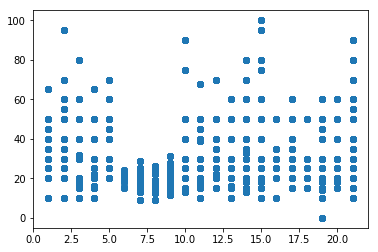

In [7]:
mpl.scatter(sdd['wave'], sdd['attr2_1'])
mpl.show()

*What we see above is that despite the "scaling" of the grades from 1-10 to a total sum of 100, the distribution is still different in waves 6-9. This is probably because when respondents were allocating 100 points, they probably gave a very high grade to a category (for instance, 75 for the importance of attractiveness) while "sacrificing" the other, less important criteria (for instance, by giving them each 5 points). On the other hand, participants from waves 6-9 didn't have to do theses "sacrifices". *

*A respondent giving attractiveness 9 points and 1 to all others was still allocating comparatively more points to the other criteria than the previous example (because 5 is 1/15 of 75, whereas 1 is 1/9 of 9). Since people probably did not think in mathematical terms when giving grades, we cannot consider that the data in these waves is matching. *

*Therefore we remove these waves. Luckily, this still leaves us with enough data to proceed.*

In [8]:
sddOK = sdd.query('wave not in [6,7,8,9]')
sddOK.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


*To continue preprocessing, we would like to get rid of all the variables that we won't use for the analysis.*

In [9]:
sddOK = sddOK.drop({'id', 'idg', 'condtn', 'position', 'positin1', 'mn_sat'} , axis=1)
sddOK.head()

,iid,gender,wave,round,order,partner,pid,match,int_corr,samerace,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,0,1,10,4,1,11.0,0,0.14,0,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,0,1,10,3,2,12.0,0,0.54,0,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,0,1,10,10,3,13.0,1,0.16,1,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,0,1,10,5,4,14.0,1,0.61,0,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,0,1,10,7,5,15.0,1,0.21,0,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


## Unsupervised Learning

### Attributes and Choice

*We would now like to visualize the difference between how people actually took their decision vs. how they thought they would take these decisions. Could it be that - at least when we only have 4 minutes to take a decision - we choose our partners differently from how we think we do it ?*

In [98]:
#First we compute what people thought mattered to them prior to the dates (average values)

Attractive_prior = np.mean(sddOK['attr1_1'])
Sincere_prior = np.mean(sddOK['sinc1_1'])
Intelligent_prior = np.mean(sddOK['intel1_1']) 
Fun_prior = np.mean(sddOK['fun1_1'])
Ambitious_prior = np.mean(sddOK['amb1_1'])
Interest_prior = np.mean(sddOK['shar1_1'])

#Then we compute what actually mattered in people's decisions after the dates (average values)

Attractive_posterior = np.mean(sddOK['attr7_2'])
Sincere_posterior = np.mean(sddOK['sinc7_2'])
Intelligent_posterior = np.mean(sddOK['intel7_2']) 
Fun_posterior = np.mean(sddOK['fun7_2'])
Ambitious_posterior = np.mean(sddOK['amb7_2'])
Interest_posterior = np.mean(sddOK['shar7_2'])

In [99]:
#We turn this into a dictionary so that we can plot the values
prior_radar_data = {'Attractive' : Attractive_prior, 'Sincere' : Sincere_prior, 'Intelligent' : Intelligent_prior, 'Fun' : Fun_prior, 'Ambitious' : Ambitious_prior, 'Interest' : Interest_prior}
prior_radar_data

{'Ambitious': 9.744157988693843,
 'Attractive': 23.982564520913655,
 'Fun': 17.352205882352926,
 'Intelligent': 20.55999851676056,
 'Interest': 11.25451492537312,
 'Sincere': 17.298111836250367}

In [100]:
#Same thing here for posterior values
posterior_radar_data = {'Attractive' : Attractive_posterior, 'Sincere' : Sincere_posterior, 'Intelligent' : Intelligent_posterior, 'Fun' : Fun_posterior, 'Ambitious' : Ambitious_posterior, 'Interest' : Interest_posterior}
posterior_radar_data

{'Ambitious': 7.28695652173913,
 'Attractive': 32.819556451612904,
 'Fun': 18.86844758064516,
 'Intelligent': 15.293850806451612,
 'Interest': 12.156028368794326,
 'Sincere': 13.529923273657289}

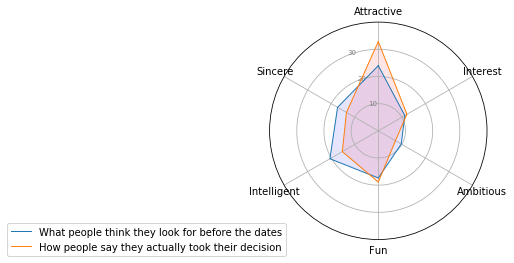

In [106]:
# number of variable
attributes=list(prior_radar_data)
N = len(attributes)

# We set at what angles each attribute will appear, since the graph is circular
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1] #so that all 6 attributes appear on the graph
angles

### Initialise the spider plot
graph = mpl.subplot(polar=True)
 
graph.set_theta_offset(np.pi / 2) #We set the offset, or "beginning" of the plot to be on top of the circle

# We reduce the number of axes to the number of attributes we want to see on our graph and add labels
# We remove the last element of the angles so that each attribute is on one concentric axis
mpl.xticks(angles[:-1], attributes) 

# Draw ylabels
#ax.set_rlabel_position(0)
mpl.yticks([10,20,30], ["10","20","30"], color="grey", size=7) #set the scale of the graph
mpl.ylim(0,40) #set the limit of the scale of the graph

### Now we add the plotted data

# Plot prior values
values_prior = list(prior_radar_data.values())
values_prior += values_prior[:1] #again we repeat the first item
graph.plot(angles, values_prior, linewidth=1, linestyle='solid', label="What people think they look for before the dates")
graph.fill(angles, values_prior, 'b', alpha=0.1)

# Plot posterior values
values_posterior = list(posterior_radar_data.values())
values_posterior += values_posterior[:1] #again we repeat the first item
graph.plot(angles, values_posterior, linewidth=1, linestyle='solid', label="How people say they actually took their decision")
graph.fill(angles, values_posterior, 'r', alpha=0.1)

# We add legend
mpl.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

mpl.show()

*The graph shows that, before the dates, people underestimate how much their partner's looks matter to them. This may be due to the fact that, in "real life", they are used to choosing their partner on criteria that take more than 4 minutes to evaluate. One explanation is that because of the time constraint linked to speed dating, people rely more heavily on criteria that can be evaluated in an instant. Another explanation is that people think of themselves as less shallow than they actually are...*

*This graph was quite useful ; let's turn the code above into a function that we can use again all throughout the analysis.*

In [77]:
def spider_plot(dic, legend):
    
    # number of variable
    attributes=list(dic)
    N = len(attributes)

    # We set at what angles each attribute will appear, since the graph is circular
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1] #so that all attributes appear on the graph
    angles

    ### Initialise the spider plot
    graph = mpl.subplot(polar=True)
 
    graph.set_theta_offset(np.pi / 2) #We set the offset, or "beginning" of the plot to be on top of the circle

    # We reduce the number of axes to the number of attributes we want to see on our graph and add labels
    # We remove the last element of the angles so that each attribute is on one concentric axis
    mpl.xticks(angles[:-1], attributes) 

    # Draw ylabels
    #ax.set_rlabel_position(0)
    mpl.yticks([10,20,30], ["10","20","30"], color="grey", size=7) #set the scale of the graph
    mpl.ylim(0,40) #set the limit of the scale of the graph

    ### Now we add the plotted data

    # Plot prior values
    data = list(dic.values())
    data += data[:1] #again we repeat the first item
    graph.plot(angles, data, linewidth=1, linestyle='solid', label=legend)
    graph.fill(angles, data, 'b', alpha=0.1)

    # We add legend
    mpl.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

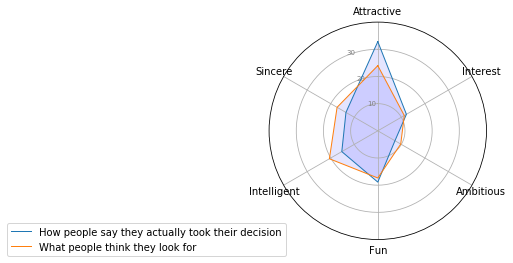

In [102]:
spider_plot(posterior_radar_data, "How people say they actually took their decision")
spider_plot(prior_radar_data, "What people think they look for")
mpl.show()

*Now that we have this useful function, let's look into this more deeply, and see whether this is the same for each gender.*

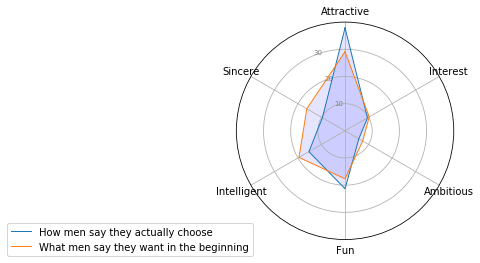

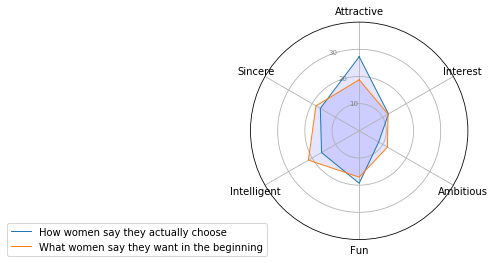

In [104]:
#We do the same steps as before for males only
sddOKM = sddOK.query('gender == 1')
MAttractive_prior = np.mean(sddOKM['attr1_1'])
MSincere_prior = np.mean(sddOKM['sinc1_1'])
MIntelligent_prior = np.mean(sddOKM['intel1_1']) 
MFun_prior = np.mean(sddOKM['fun1_1'])
MAmbitious_prior = np.mean(sddOKM['amb1_1'])
MInterest_prior = np.mean(sddOKM['shar1_1'])

sddOKMMatch = sddOKM.query('match == 1')
MAttractive_posterior = np.mean(sddOKMMatch['attr7_2'])
MSincere_posterior = np.mean(sddOKMMatch['sinc7_2'])
MIntelligent_posterior = np.mean(sddOKMMatch['intel7_2']) 
MFun_posterior = np.mean(sddOKMMatch['fun7_2'])
MAmbitious_posterior = np.mean(sddOKMMatch['amb7_2'])
MInterest_posterior = np.mean(sddOKMMatch['shar7_2'])

Mprior_radar_data = {'Attractive' : MAttractive_prior, 'Sincere' : MSincere_prior, 'Intelligent' : MIntelligent_prior, 'Fun' : MFun_prior, 'Ambitious' : MAmbitious_prior, 'Interest' : MInterest_prior}
Mposterior_radar_data = {'Attractive' : MAttractive_posterior, 'Sincere' : MSincere_posterior, 'Intelligent' : MIntelligent_posterior, 'Fun' : MFun_posterior, 'Ambitious' : MAmbitious_posterior, 'Interest' : MInterest_posterior}

#And now the same for females. 
sddOKF = sddOK.query('gender == 0')
FAttractive_prior = np.mean(sddOKF['attr1_1'])
FSincere_prior = np.mean(sddOKF['sinc1_1'])
FIntelligent_prior = np.mean(sddOKF['intel1_1']) 
FFun_prior = np.mean(sddOKF['fun1_1'])
FAmbitious_prior = np.mean(sddOKF['amb1_1'])
FInterest_prior = np.mean(sddOKF['shar1_1'])

sddOKFMatch = sddOKF.query('match == 1')
FAttractive_posterior = np.mean(sddOKFMatch['attr7_2'])
FSincere_posterior = np.mean(sddOKFMatch['sinc7_2'])
FIntelligent_posterior = np.mean(sddOKFMatch['intel7_2']) 
FFun_posterior = np.mean(sddOKFMatch['fun7_2'])
FAmbitious_posterior = np.mean(sddOKFMatch['amb7_2'])
FInterest_posterior = np.mean(sddOKFMatch['shar7_2'])

Fprior_radar_data = {'Attractive' : FAttractive_prior, 'Sincere' : FSincere_prior, 'Intelligent' : FIntelligent_prior, 'Fun' : FFun_prior, 'Ambitious' : FAmbitious_prior, 'Interest' : FInterest_prior}
Fposterior_radar_data = {'Attractive' : FAttractive_posterior, 'Sincere' : FSincere_posterior, 'Intelligent' : FIntelligent_posterior, 'Fun' : FFun_posterior, 'Ambitious' : FAmbitious_posterior, 'Interest' : FInterest_posterior}

#And now we plot everything. 

spider_plot(Mposterior_radar_data, "How men say they actually choose")
spider_plot(Mprior_radar_data, "What men say they want in the beginning")
mpl.show()
spider_plot(Fposterior_radar_data, "How women say they actually choose")
spider_plot(Fprior_radar_data, "What women say they want in the beginning")
mpl.show()

*Splitting the graph we had before into these two graphs lets us know that on average men are more aware than women of what they actually want (especially for ambition, fun, and shared interests), whereas women are less consistent (especially when it comes to ambition, which is important according to what they say, but not according to who they choose). Men are also more likely than women to admit directly how much attractiveness matters to them. *

*This is quite interesting, but we can go further. Instead of looking at the difference between what people said they wanted in the beginning, and how they said they made their choices, why not directly at how they **actually** made their choice?*

**WORK IN PROGRESS**

In [96]:
Attractive_prior = np.mean(sddOK['attr1_1'])/10
Sincere_prior = np.mean(sddOK['sinc1_1'])/10
Intelligent_prior = np.mean(sddOK['intel1_1'])/10 
Fun_prior = np.mean(sddOK['fun1_1'])/10
Ambitious_prior = np.mean(sddOK['amb1_1'])/10
Interest_prior = np.mean(sddOK['shar1_1'])/10

#Then we compute what actually mattered in people's decisions during the dates, when a match occured (average values)
sddmatch = sddOK.query('match == 1')

Attractive_posterior = np.mean(sddmatch['attr'])
Sincere_posterior = np.mean(sddmatch['sinc'])
Intelligent_posterior = np.mean(sddmatch['intel']) 
Fun_posterior = np.mean(sddmatch['fun'])
Ambitious_posterior = np.mean(sddmatch['amb'])
Interest_posterior = np.mean(sddmatch['shar'])


In [85]:
#First, let's look at what people say they want, and what they actually want, and compute the difference
sddDiff = sddmatch[['iid', 'gender', 'attr1_1', 'sinc1_1', 'fun1_1', 'intel1_1', 'amb1_1', 'attr7_2', 'sinc7_2', 'fun7_2', 'intel7_2', 'amb7_2']]
sddDiff['err_attr'] = sddDiff['attr1_1'] - sddDiff['attr7_2']
sddDiff['err_sinc'] = sddDiff['sinc1_1'] - sddDiff['sinc7_2']
sddDiff['err_fun'] = sddDiff['fun1_1'] - sddDiff['fun7_2']
sddDiff['err_intel'] = sddDiff['intel1_1'] - sddDiff['intel7_2']
sddDiff['err_amb'] = sddDiff['amb1_1'] - sddDiff['amb7_2']

sddDiff = sddDiff.groupby('iid').agg({'gender' : 'mean','attr1_1' : 'mean', 'sinc1_1' : 'mean', 'fun1_1' : 'mean', 'intel1_1' : 'mean', 'amb1_1' : 'mean', 'attr7_2' : 'mean', 'sinc7_2' : 'mean', 'fun7_2' : 'mean', 'intel7_2' : 'mean', 'amb7_2' : 'mean', 'err_attr': 'mean','err_sinc': 'mean', 'err_fun': 'mean', 'err_intel': 'mean', 'err_amb': 'mean'})
sddDiff = sddDiff.dropna(axis=0, how='any') #dropping values for attributes ***7_2 not available
sddDiff.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,gender,attr1_1,sinc1_1,fun1_1,intel1_1,amb1_1,attr7_2,sinc7_2,fun7_2,intel7_2,amb7_2,err_attr,err_sinc,err_fun,err_intel,err_amb
iid,,,,,,,,,,,,,,,,
381,0,20.0,10.0,35.0,20.0,5.0,40.0,15.0,15.0,20.0,5.0,-20.0,-5.0,20.0,0.0,0.0
383,0,25.0,20.0,20.0,10.0,15.0,25.0,15.0,15.0,20.0,20.0,0.0,5.0,5.0,-10.0,-5.0
384,0,20.0,20.0,20.0,20.0,20.0,30.0,10.0,20.0,10.0,10.0,-10.0,10.0,0.0,10.0,10.0
386,0,15.0,10.0,10.0,30.0,15.0,15.0,20.0,15.0,20.0,15.0,0.0,-10.0,-5.0,10.0,0.0
387,0,20.0,15.0,15.0,25.0,15.0,20.0,20.0,20.0,15.0,10.0,0.0,-5.0,-5.0,10.0,5.0


In [ ]:
%matplotlib inline
sddDiff['attr1_1'].plot.hist(alpha=1, bins = 10)
sddDiff['attr7_2'].plot.hist(alpha=0.5, bins = 10)
mpl.title("Attractiveness - Desire vs. Reality")
mpl.show()
sddDiff['sinc1_1'].plot.hist(alpha=1, bins = 10)
sddDiff['sinc7_2'].plot.hist(alpha=0.5, bins = 10)
mpl.title("Sincerity - Desire vs. Reality")
mpl.show()
sddDiff['fun1_1'].plot.hist(alpha=1, bins = 10)
sddDiff['fun7_2'].plot.hist(alpha=0.5, bins = 10)
mpl.title("Fun - Desire vs. Reality")
mpl.show()
sddDiff['intel1_1'].plot.hist(alpha=1, bins = 10)
sddDiff['intel7_2'].plot.hist(alpha=0.5, bins = 10)
mpl.title("Intelligence - Desire vs. Reality")
mpl.show()
sddDiff['amb1_1'].plot.hist(alpha=1, bins = 10)
sddDiff['amb7_2'].plot.hist(alpha=0.5, bins = 10)
mpl.title("Ambition - Desire vs. Reality")
mpl.show()

### Attributes and Self-Assessment

*Now, let's look at all the self assessment data. People were asked to rate themselves according to the different attributes, then to express how they thought people rated them, and lastly they were actually rated by other people. 
Let's see how self-perception differs from actual perception by others, using the same method as before.*

*For this part, we'll put aside Shared Interest, which can't be compared from one person to another because it depends largely on who is the observer, rather than the actual subject*

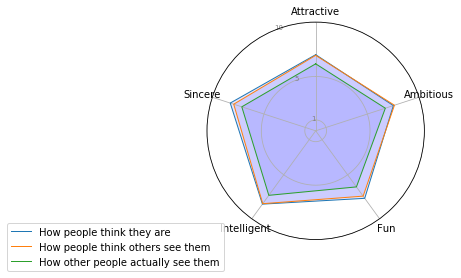

In [17]:
Attractive_self = np.mean(sddOK['attr3_1'])
Sincere_self = np.mean(sddOK['sinc3_1'])
Intelligent_self = np.mean(sddOK['intel3_1']) 
Fun_self = np.mean(sddOK['fun3_1'])
Ambitious_self = np.mean(sddOK['amb3_1'])

Attractive_perceived = np.mean(sddOK['attr5_1'])
Sincere_perceived = np.mean(sddOK['sinc5_1'])
Intelligent_perceived = np.mean(sddOK['intel5_1']) 
Fun_perceived = np.mean(sddOK['fun5_1'])
Ambitious_perceived = np.mean(sddOK['amb5_1'])

Attractive_observed = np.mean(sddOK['attr_o'])
Sincere_observed = np.mean(sddOK['sinc_o'])
Intelligent_observed = np.mean(sddOK['intel_o']) 
Fun_observed = np.mean(sddOK['fun_o'])
Ambitious_observed = np.mean(sddOK['amb_o'])

Self_radar_data = {'Attractive' : Attractive_self, 'Sincere' : Sincere_self, 'Intelligent' : Intelligent_self, 'Fun' : Fun_self, 'Ambitious' : Ambitious_self}
Perceived_radar_data = {'Attractive' : Attractive_perceived, 'Sincere' : Sincere_perceived, 'Intelligent' : Intelligent_perceived, 'Fun' : Fun_perceived, 'Ambitious' : Ambitious_perceived}
Observed_radar_data = {'Attractive' : Attractive_observed, 'Sincere' : Sincere_observed, 'Intelligent' : Intelligent_observed, 'Fun' : Fun_observed, 'Ambitious' : Ambitious_observed}

spider_plot(Self_radar_data, "How people think they are")
spider_plot(Perceived_radar_data, "How people think others see them")
spider_plot(Observed_radar_data, "How other people actually see them")
mpl.yticks([1,5,10], ["1","5","10"], color="grey", size=7) #set the scale of the graph
mpl.ylim(0,10) #set the limit of the scale of the graph
mpl.show()

*This graph is very interesting. It shows that on average, people think others see them as they think they are.
But actually, everyone significantly overestimates his attributes : everyone thinks he is better than he actually is. 
It might also be linked to the very short amount of time given for the speed dating sessions, that doesn't enable people to get to know each other sufficiently*

*Let's see whether one gender is more realistic than the other.*

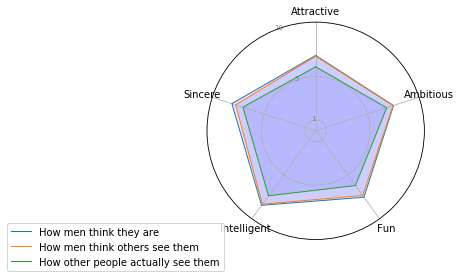

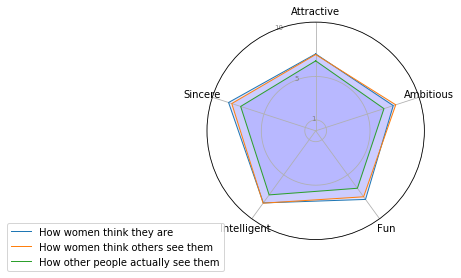

In [18]:
MAttractive_self = np.mean(sddOKM['attr3_1'])
MSincere_self = np.mean(sddOKM['sinc3_1'])
MIntelligent_self = np.mean(sddOKM['intel3_1']) 
MFun_self = np.mean(sddOKM['fun3_1'])
MAmbitious_self = np.mean(sddOKM['amb3_1'])

MAttractive_perceived = np.mean(sddOKM['attr5_1'])
MSincere_perceived = np.mean(sddOKM['sinc5_1'])
MIntelligent_perceived = np.mean(sddOKM['intel5_1']) 
MFun_perceived = np.mean(sddOKM['fun5_1'])
MAmbitious_perceived = np.mean(sddOKM['amb5_1'])

MAttractive_observed = np.mean(sddOKM['attr_o'])
MSincere_observed = np.mean(sddOKM['sinc_o'])
MIntelligent_observed = np.mean(sddOKM['intel_o']) 
MFun_observed = np.mean(sddOKM['fun_o'])
MAmbitious_observed = np.mean(sddOKM['amb_o'])

MSelf_radar_data = {'Attractive' : MAttractive_self, 'Sincere' : MSincere_self, 'Intelligent' : MIntelligent_self, 'Fun' : MFun_self, 'Ambitious' : MAmbitious_self}
MPerceived_radar_data = {'Attractive' : MAttractive_perceived, 'Sincere' : MSincere_perceived, 'Intelligent' : MIntelligent_perceived, 'Fun' : MFun_perceived, 'Ambitious' : MAmbitious_perceived}
MObserved_radar_data = {'Attractive' : MAttractive_observed, 'Sincere' : MSincere_observed, 'Intelligent' : MIntelligent_observed, 'Fun' : MFun_observed, 'Ambitious' : MAmbitious_observed}

spider_plot(MSelf_radar_data, "How men think they are")
spider_plot(MPerceived_radar_data, "How men think others see them")
spider_plot(MObserved_radar_data, "How other people actually see them")
mpl.yticks([1,5,10], ["1","5","10"], color="grey", size=7) #set the scale of the graph
mpl.ylim(0,10) #set the limit of the scale of the graph
mpl.show()

FAttractive_self = np.mean(sddOKF['attr3_1'])
FSincere_self = np.mean(sddOKF['sinc3_1'])
FIntelligent_self = np.mean(sddOKF['intel3_1']) 
FFun_self = np.mean(sddOKF['fun3_1'])
FAmbitious_self = np.mean(sddOKF['amb3_1'])

FAttractive_perceived = np.mean(sddOKF['attr5_1'])
FSincere_perceived = np.mean(sddOKF['sinc5_1'])
FIntelligent_perceived = np.mean(sddOKF['intel5_1']) 
FFun_perceived = np.mean(sddOKF['fun5_1'])
FAmbitious_perceived = np.mean(sddOKF['amb5_1'])

FAttractive_observed = np.mean(sddOKF['attr_o'])
FSincere_observed = np.mean(sddOKF['sinc_o'])
FIntelligent_observed = np.mean(sddOKF['intel_o']) 
FFun_observed = np.mean(sddOKF['fun_o'])
FAmbitious_observed = np.mean(sddOKF['amb_o'])

FSelf_radar_data = {'Attractive' : FAttractive_self, 'Sincere' : FSincere_self, 'Intelligent' : FIntelligent_self, 'Fun' : FFun_self, 'Ambitious' : FAmbitious_self}
FPerceived_radar_data = {'Attractive' : FAttractive_perceived, 'Sincere' : FSincere_perceived, 'Intelligent' : FIntelligent_perceived, 'Fun' : FFun_perceived, 'Ambitious' : FAmbitious_perceived}
FObserved_radar_data = {'Attractive' : FAttractive_observed, 'Sincere' : FSincere_observed, 'Intelligent' : FIntelligent_observed, 'Fun' : FFun_observed, 'Ambitious' : FAmbitious_observed}

spider_plot(FSelf_radar_data, "How women think they are")
spider_plot(FPerceived_radar_data, "How women think others see them")
spider_plot(FObserved_radar_data, "How other people actually see them")
mpl.yticks([1,5,10], ["1","5","10"], color="grey", size=7) #set the scale of the graph
mpl.ylim(0,10) #set the limit of the scale of the graph
mpl.show()


*There is apparently not much difference for both genders on this, except that on average women are better at accurately judging their attractiveness, whereas men tend to overestimate it by much.*

*Now let's look at this more in depth by looking at the distribution of these values to better understand what type of law these distributions follow, and whether we can find some insightful observations related to the errors.*

In [38]:
#First, let's look at self assessment of attributes and compute the difference
sddSA = sddOK[['iid', 'gender', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr_o', 'sinc_o', 'fun_o', 'intel_o', 'amb_o']]
sddSA['err_attr'] = sddSA['attr3_1'] - sddSA['attr_o']
sddSA['err_sinc'] = sddSA['sinc3_1'] - sddSA['sinc_o']
sddSA['err_fun'] = sddSA['fun3_1'] - sddSA['fun_o']
sddSA['err_intel'] = sddSA['intel3_1'] - sddSA['intel_o']
sddSA['err_amb'] = sddSA['amb3_1'] - sddSA['amb_o']

sddSA = sddSA.groupby('iid').agg({'gender' : 'mean','attr3_1' : 'mean', 'sinc3_1' : 'mean', 'fun3_1' : 'mean', 'intel3_1' : 'mean', 'amb3_1' : 'mean', 'attr_o' : 'mean', 'sinc_o' : 'mean', 'fun_o' : 'mean', 'intel_o' : 'mean', 'amb_o' : 'mean', 'err_attr': 'mean','err_sinc': 'mean', 'err_fun': 'mean', 'err_intel': 'mean', 'err_amb': 'mean'})

#It should be noted here that the error IS NOT the difference between the average of the two columns, but the average difference, which makes more sense because we substract two integers rather than one integer and one decimal number'
sddSA.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,gender,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr_o,sinc_o,fun_o,intel_o,amb_o,err_attr,err_sinc,err_fun,err_intel,err_amb
iid,,,,,,,,,,,,,,,,
1,0,6.0,8.0,8.0,8.0,7.0,6.7,7.4,7.2,8.0,8.000000,-0.7,0.6,0.8,0.0,-1.000000
2,0,7.0,5.0,10.0,8.0,3.0,7.7,7.1,7.5,7.9,7.500000,-0.7,-2.1,2.5,0.1,-4.500000
3,0,8.0,9.0,8.0,9.0,8.0,6.5,7.1,6.2,7.3,7.111111,1.5,1.9,1.8,1.7,0.888889
4,0,7.0,8.0,9.0,7.0,8.0,7.0,7.1,7.5,7.7,7.700000,0.0,0.9,1.5,-0.7,0.300000
5,0,6.0,3.0,6.0,10.0,8.0,5.3,7.7,7.2,7.6,7.800000,0.7,-4.7,-1.2,2.4,0.200000


*Now let's look at the distribution of those values.*

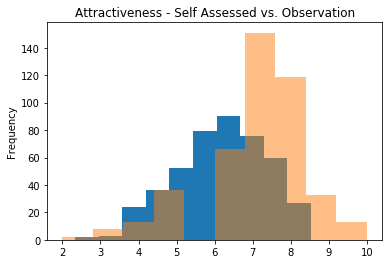

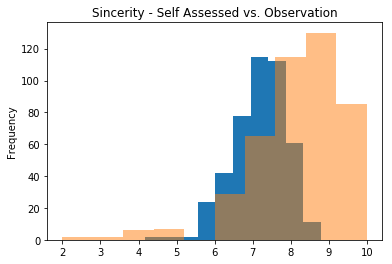

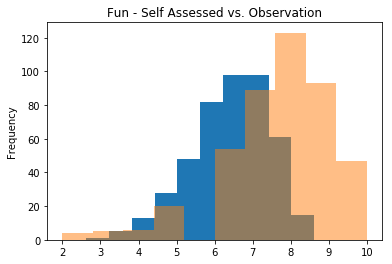

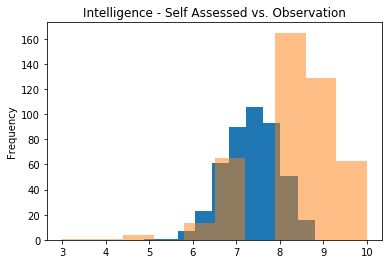

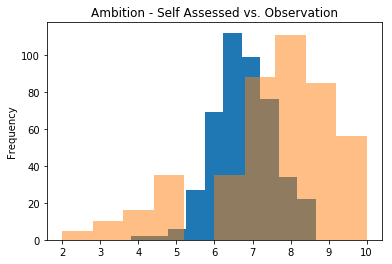

In [40]:
%matplotlib inline
sddSA['attr_o'].plot.hist(alpha=1, bins = 10)
sddSA['attr3_1'].plot.hist(alpha=0.5, bins = 10)
mpl.title("Attractiveness - Self Assessed vs. Observation")
mpl.show()
sddSA['sinc_o'].plot.hist(alpha=1, bins = 10)
sddSA['sinc3_1'].plot.hist(alpha=0.5, bins = 10)
mpl.title("Sincerity - Self Assessed vs. Observation")
mpl.show()
sddSA['fun_o'].plot.hist(alpha=1, bins = 10)
sddSA['fun3_1'].plot.hist(alpha=0.5, bins = 10)
mpl.title("Fun - Self Assessed vs. Observation")
mpl.show()
sddSA['intel_o'].plot.hist(alpha=1, bins = 10)
sddSA['intel3_1'].plot.hist(alpha=0.5, bins = 10)
mpl.title("Intelligence - Self Assessed vs. Observation")
mpl.show()
sddSA['amb_o'].plot.hist(alpha=1, bins = 10)
sddSA['amb3_1'].plot.hist(alpha=0.5, bins = 10)
mpl.title("Ambition - Self Assessed vs. Observation")
mpl.show()

*In each case, we observe significant overestimations of self-assessed attributes compared to observed attributes, which is logical considering what we saw above.*
- Attractiveness : people (and mostly men) tend to overestimate their attractiveness. It actually follows a distribution close to normal with mean 6, but self-assessment data is much more concentrated, around 7 and 8. People judging themselves as hugely attractive actually do not please everyone, which is why there is no one above 9. Attractiveness seems to really depend on the point of view of the potential partner.
- Sincerity : actual perceived sincerity doesn't seem to have a wide range - most people are between 6 and 8. No one is perceived as very sincere, or not sincere. This suggests that people can't very well judge sincerity in such a short span of time, and that sincerity is not really relevant as an attribute.
- Fun : the actual fun seems to have a very similar distribution as self-assessed fun, but with a lesser range, and a uniform average error of two points. 
- Intelligence : no one regards himself as low intelligence, and people don't judge intelligence harshly - no one is below 5, which is surprising compared to the low values that can be attained for fun. Intelligence is hard to judge in so short of a time, and people are most likely reluctant to judge others as stupid after only 5 minutes of conversation.
- Ambition : no one is perceived by all his potentials partners as having very high ambition or very low ambition, distribution of observed ambition is pretty concentrated around 6.5. This is interesting because ambition is the only attribute for which the self-assessed value is more related to the actual ambition than the perceived value, because it is a personal drive. So people with very low ambition (resp. very high ambition) seem to come across as more (resp. less) ambitious that they are - maybe because they think this makes them more attractive ? Is it conscious or not ?  

*Now let's see if there is any relationship between the values of the self assessed attributes and the errors. Are people more likely to be right about their intelligence, or attractiveness, if they are really intelligent or attractive ?*

In [50]:
#let's change the errors to get square errors, and sum them, to get SSE for each person and each attribute
sddSA = sddOK[['iid', 'gender', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr_o', 'sinc_o', 'fun_o', 'intel_o', 'amb_o']]
sddSA['err_attr'] = (sddSA['attr3_1'] - sddSA['attr_o'])**2
sddSA['err_sinc'] = (sddSA['sinc3_1'] - sddSA['sinc_o'])**2
sddSA['err_fun'] = (sddSA['fun3_1'] - sddSA['fun_o'])**2
sddSA['err_intel'] = (sddSA['intel3_1'] - sddSA['intel_o'])**2
sddSA['err_amb'] = (sddSA['amb3_1'] - sddSA['amb_o'])**2

sddSA = sddSA.groupby('iid').agg({'gender' : 'mean','attr3_1' : 'mean', 'sinc3_1' : 'mean', 'fun3_1' : 'mean', 'intel3_1' : 'mean', 'amb3_1' : 'mean', 'attr_o' : 'mean', 'sinc_o' : 'mean', 'fun_o' : 'mean', 'intel_o' : 'mean', 'amb_o' : 'mean', 'err_attr': 'sum','err_sinc': 'sum', 'err_fun': 'sum', 'err_intel': 'sum', 'err_amb': 'sum'})

#We look at the average SSE, because we don't want our analysis to be biased if some grades are under represented
sddSAErrAttr = sddSA.groupby('attr3_1').agg({'err_attr': 'mean'})
sddSAErrSinc = sddSA.groupby('sinc3_1').agg({'err_sinc': 'mean'})
sddSAErrFun = sddSA.groupby('fun3_1').agg({'err_fun': 'mean'})
sddSAErrIntel = sddSA.groupby('intel3_1').agg({'err_intel': 'mean'})
sddSAErrAmb = sddSA.groupby('amb3_1').agg({'err_amb': 'mean'})

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

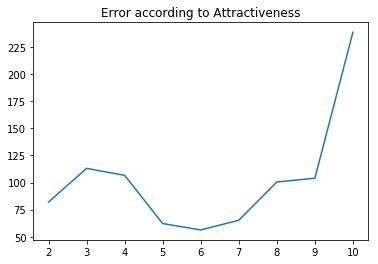

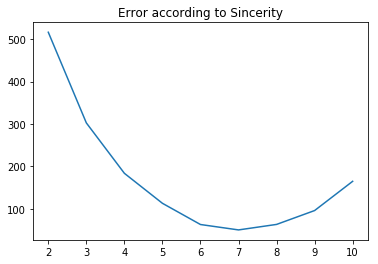

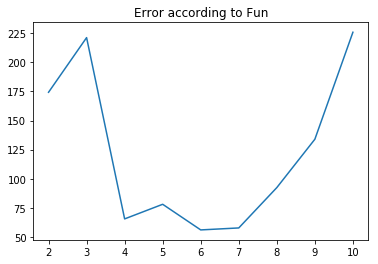

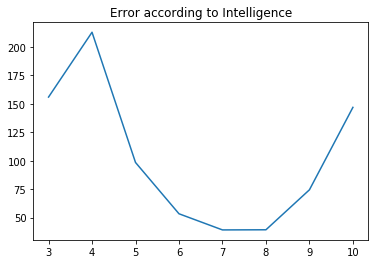

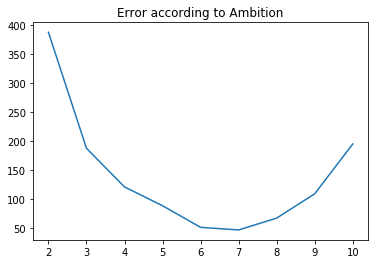

In [51]:
%matplotlib inline

mpl.plot(sddSAErrAttr)
mpl.title("Error according to Attractiveness")
mpl.show()

mpl.plot(sddSAErrSinc)
mpl.title("Error according to Sincerity")
mpl.show()

mpl.plot(sddSAErrFun)
mpl.title("Error according to Fun")
mpl.show()

mpl.plot(sddSAErrIntel)
mpl.title("Error according to Intelligence")
mpl.show()

mpl.plot(sddSAErrAmb)
mpl.title("Error according to Ambition")
mpl.show()

In [54]:
#just checking a few observations to understand if certain plots are biased by outliers
sddSA.query('attr3_1 == 2')

,gender,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr_o,sinc_o,fun_o,intel_o,amb_o,err_attr,err_sinc,err_fun,err_intel,err_amb
iid,,,,,,,,,,,,,,,,
121,0,2.0,9.0,9.0,7.0,9.0,4.8,6.5,4.8,7.2,5.4,108.0,121.0,230.0,44.0,164.0
451,1,2.0,4.0,4.0,4.0,4.0,2.8,7.3,4.8,8.3,8.1,56.0,141.0,46.0,213.0,199.0


In [57]:
sddSA.query('intel3_1 == 3')

,gender,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr_o,sinc_o,fun_o,intel_o,amb_o,err_attr,err_sinc,err_fun,err_intel,err_amb
iid,,,,,,,,,,,,,,,,
240,0,3.0,8.0,5.0,3.0,6.0,6.777778,7.111111,8.0,7.0,7.333333,138.0,14.0,101.0,156.0,52.0


*Other things that we checked don't seem to lead to any problem due to a lack of data. Let's just ignore the points generated by one or two observations, as shown by the queries above, and analyze.*

*Overall, errors are most important for the lowest and highest values. This is not a surprise : given the number of speed dates, the probability of someone constantly receiving the same very low grade or the same very high grade is quite low.*
*Still, it's comforting for people feeling like they fare very poorly at a given attribute : they are most likely wrong*
*On average, it appears that people ranking themselves at 7 for a given attribute (6 for Attractiveness) are the most likely to be right about themselves.*